<a href="https://colab.research.google.com/github/p42777/graph_conv_net/blob/main/msg_passing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%matplotlib inline

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm 
from scipy.special import softmax
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from matplotlib import animation

In [12]:
A = np.array([[0, 1, 0, 0, 0], [1, 0, 1, 0, 0], [0, 1, 0, 1, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]])
print("A: \n", A)
print("\n")

features = np.arange(A.shape[0]).reshape((-1,1))+1
print("features: \n", features)
print("\n")

H = A @ features
print("H: \n", H)

A: 
 [[0 1 0 0 0]
 [1 0 1 0 0]
 [0 1 0 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]


features: 
 [[1]
 [2]
 [3]
 [4]
 [5]]


H: 
 [[ 2]
 [ 4]
 [11]
 [ 3]
 [ 3]]


# **Neighborhood Sum**

In [13]:
D = np.zeros(A.shape)
np.fill_diagonal(D, A.sum(axis = 0))
print("D: \n", D)
print("\n")

D_inverse = np.linalg.inv(D)
print("Inverse of D: \n", D_inverse)
print("\n")

H_average = D_inverse @ A @ features
print("Mean of H: \n", H_average)

D: 
 [[1. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 3. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


Inverse of D: 
 [[1.         0.         0.         0.         0.        ]
 [0.         0.5        0.         0.         0.        ]
 [0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


Mean of H: 
 [[2.        ]
 [2.        ]
 [3.66666667]
 [3.        ]
 [3.        ]]


# **Normalized Adjacency Matrix : $\hat{A}=\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$**

In [14]:
graph = nx.from_numpy_array(A)
A_tilde = A + np.eye(graph.number_of_nodes())

# D for A_tilde:
D_tilde = np.zeros_like(A_tilde)
np.fill_diagonal(D_tilde, A_tilde.sum(axis=1).flatten())

# Inverse square root of D:
D_tilde_inverse = np.linalg.inv(sqrtm(D_tilde))

print("D tilde: \n", D_tilde)
print("\n")
print("Inverse square root of D: \n", D_tilde_inverse)

D tilde: 
 [[2. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 0. 4. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 2.]]


Inverse square root of D: 
 [[0.70710678 0.         0.         0.         0.        ]
 [0.         0.57735027 0.         0.         0.        ]
 [0.         0.         0.5        0.         0.        ]
 [0.         0.         0.         0.70710678 0.        ]
 [0.         0.         0.         0.         0.70710678]]


{0: array([-0.875, -0.375]), 1: array([ 1.   , -0.375]), 2: array([0.375, 0.25 ]), 3: array([-0.5625, -0.0625]), 4: array([0.0625, 0.5625])}


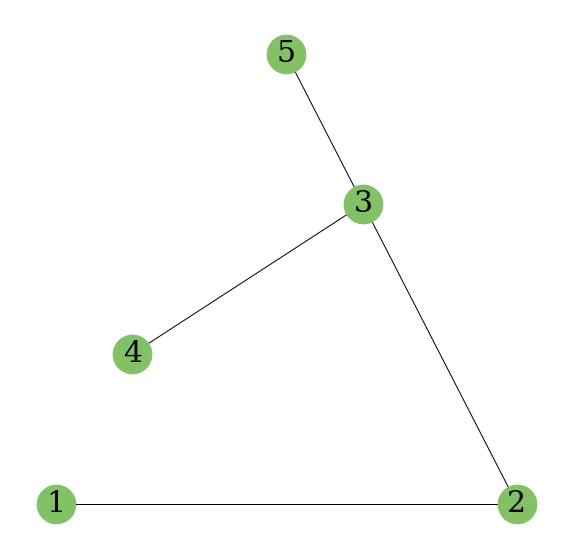

In [15]:
labels = {i: i+1 for i in range(graph.number_of_nodes())}
pos = nx.planar_layout(graph)

fig, ax = plt.subplots(figsize = (10,10))
nx.draw(graph, pos, with_labels=True, labels = labels, node_color = '#83C167', ax = ax, edge_color = 'black', node_size = 1500, font_size = 30, font_family = 'serif')
plt.savefig('graph.png', bbox_inches = 'tight', transparent = True)
print(pos)

In [17]:
A_hat = D_tilde_inverse @ A_tilde @ D_tilde_inverse

In [21]:
H = np.zeros((graph.number_of_nodes(), 1))
H[0,0] = 1 
results = [H.flatten()]

for i in range(10):
    H = A_hat @ H
    results.append(H.flatten())

print(f"Initial signal input: {results[0]}")
print(f"Final signal output after running 10 steps of message-passing:  {results[-1]}")

Initial signal input: [1. 0. 0. 0. 0.]
Final signal output after running 10 steps of message-passing:  [0.18381719 0.20791335 0.20436693 0.13626176 0.13626176]


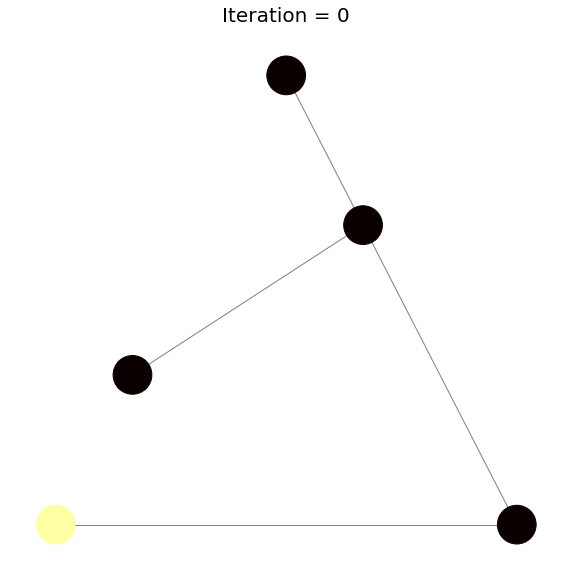

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

kwargs = {'cmap': 'hot', 'node_size': 1500, 'edge_color': 'gray', 'vmin': np.array(results).min(), 'vmax': np.array(results).max()*1.1}

def update(idx):
    ax.clear()
    colors = results[idx]
    nx.draw(graph, pos, node_color = colors, ax = ax, **kwargs)
    ax.set_title(f"Iteration = {idx}", fontsize=20)

anim = animation.FuncAnimation(fig, update, frames = len(results), interval = 1000, repeat = True)

In [26]:
anim.save('result.mp4', dpi=600, bitrate=-1,savefig_kwargs={'transparent': True, 'facecolor': 'none'})
from IPython.display import HTML
HTML(anim.to_html5_video())